In [30]:
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# A. Feature Extraction

In [2]:
date_parse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
raw_data = pd.read_csv('../../data/trade_new.csv', index_col=0, parse_dates=['sldatime'], date_parser=date_parse).fillna(-1)
raw_data = raw_data.sort_values('sldatime')
raw_data = raw_data.reset_index(drop=True)

raw_data['date'] = raw_data.sldatime.dt.date
raw_data['bndno'] = raw_data['bndno'].astype('int')

## TYPE 1:

In [6]:
# extract the count features 
# note that sub should fit the forms of ['vipno'] or ['vipno', 'pluno']
# marks = ['U', 'B', 'C', 'I', 'UB', 'UC', 'UI', 'BC']
def extract_feature_UBCI(df, sub, mark):
    n = len(sub)
    f_name = ['num_' + mark, 'amt_' + mark, 'days_' + mark]
    print('Feature names are: ', f_name)
    profile = pd.DataFrame(columns = sub + f_name)
    groups = df.groupby(sub)

    for no, group_data in groups:
        num = len(group_data)
        amt = group_data.amt.sum()
        days = group_data.date.nunique()
        if n == 1:
            t = pd.Series([no, num, amt, days], index=sub + f_name, dtype='int64')
        else:
            t = pd.Series([no[0], no[1], num, amt, days], index=sub + f_name, dtype='int64')
        profile = profile.append(t, ignore_index=True)
        
    print("The DataFrame's row number is :", len(profile))
    print(profile.iloc[[1,-1],:])
    print('='*50)
    return profile

data_temp = raw_data.query('20160201 <= sldatime < 20160301').copy()
# f_count_U = extract_feature_UBCI(data_temp, ['vipno'], 'U')
# f_count_B = extract_feature_UBCI(data_temp, ['bndno'], 'B')
# f_count_C = extract_feature_UBCI(data_temp, ['dptno'], 'C')
# f_count_I = extract_feature_UBCI(data_temp, ['pluno'], 'I')
# f_count_U_B = extract_feature_UBCI(data_temp, ['vipno', 'bndno'], 'UB')
# f_count_U_C = extract_feature_UBCI(data_temp, ['vipno', 'dptno'], 'UC')
# f_count_U_I = extract_feature_UBCI(data_temp, ['vipno', 'pluno'], 'UI')
# f_count_B_C = extract_feature_UBCI(data_temp, ['bndno', 'dptno'], 'BC')
extract_feature_UBCI(data_temp, ['vipno'], 'U').head()

Feature names are:  ['num_U', 'amt_U', 'days_U']
The DataFrame's row number is : 318
                   vipno num_U amt_U days_U
1          1590120718170     2    11      1
317  6227002180921663895     7    48      2


,vipno,num_U,amt_U,days_U
0,1590120464497,22,305,2
1,1590120718170,2,11,1
2,1590130640102,16,67,8
3,1590130817948,6,74,2
4,1590140304209,39,274,6


In [7]:
# extract the product diversity features 
# note that sub should fit the forms of ['vipno', 'pluno']
# marks = ['U_I', 'U_B', 'U_C', 'B_I', 'C_I']
def extract_feature_diversity(df, sub, mark):
    f_name = ['prod_' + mark]
    print('Feature names are: ', f_name)
    PK = sub[0]
    index = [PK] + f_name
    
    profile = pd.DataFrame(columns = index)
    groups = df.groupby(PK)

    for no, group_data in groups:
        product_diversity = group_data[sub[1]].nunique()
        t = pd.Series([no, product_diversity], index=index, dtype='int64')
        profile = profile.append(t, ignore_index=True)
        
    print("The DataFrame's row number is :", len(profile))
    print(profile.iloc[[1,-1],:])
    print('='*50)
    return profile

data_temp = raw_data.query('20160201 <= sldatime < 20160301').copy()
# f_diver_U_I = extract_feature_diversity(data_temp, ['vipno', 'pluno'], 'U_I')
# f_diver_U_B = extract_feature_diversity(data_temp, ['vipno', 'bndno'], 'U_B')
# f_diver_U_C = extract_feature_diversity(data_temp, ['vipno', 'dptno'], 'U_C')
# f_diver_B_I = extract_feature_diversity(data_temp, ['bndno', 'pluno'], 'B_I')
# f_diver_C_I = extract_feature_diversity(data_temp, ['dptno', 'pluno'], 'C_I')
# f_diver_B_U = extract_feature_diversity(data_temp, ['bndno', 'vipno'], 'B_U')
# f_diver_C_U = extract_feature_diversity(data_temp, ['dptno', 'vipno'], 'C_U')
# f_diver_I_U = extract_feature_diversity(data_temp, ['pluno', 'vipno'], 'I_U')
extract_feature_diversity(data_temp, ['vipno', 'pluno'], 'U_I').head()

Feature names are:  ['prod_U_I']
The DataFrame's row number is : 318
                   vipno prod_U_I
1          1590120718170        1
317  6227002180921663895        7


,vipno,prod_U_I
0,1590120464497,19
1,1590120718170,1
2,1590130640102,11
3,1590130817948,5
4,1590140304209,29


In [8]:
feature_user = {
    'count_U': (extract_feature_UBCI, ['vipno'], 'U'),
    'diver_U_I': (extract_feature_diversity, ['vipno', 'pluno'], 'U_I'),
    'diver_U_B': (extract_feature_diversity, ['vipno', 'bndno'], 'U_B'),
    'diver_U_C': (extract_feature_diversity, ['vipno', 'dptno'], 'U_C'),
}

feature_brand = {
    'count_B': (extract_feature_UBCI, ['bndno'], 'B'),
    'diver_B_I': (extract_feature_diversity, ['bndno', 'pluno'], 'B_I'),
    'diver_B_U': (extract_feature_diversity, ['bndno', 'vipno'], 'B_U'),
}

feature_category = {
    'count_C': (extract_feature_UBCI, ['dptno'], 'C'),
    'diver_C_I': (extract_feature_diversity, ['dptno', 'pluno'], 'C_I'),
    'diver_C_U': (extract_feature_diversity, ['dptno', 'vipno'], 'C_U'),
}

feature_item = {
    'count_I': (extract_feature_UBCI, ['pluno'], 'I'),
    'diver_I_U': (extract_feature_diversity, ['pluno', 'vipno'], 'I_U'),
}

feature_dict = {
    'vipno': feature_user,
    'bndno': feature_brand,
    'dptno': feature_category,
    'pluno': feature_item,
}

# remain to be added
# f_count_U_B = extract_feature_UBCI(data_temp, ['vipno', 'bndno'], 'UB')
# f_count_U_C = extract_feature_UBCI(data_temp, ['vipno', 'dptno'], 'UC')
# f_count_U_I = extract_feature_UBCI(data_temp, ['vipno', 'pluno'], 'UI')
# f_count_B_C = extract_feature_UBCI(data_temp, ['bndno', 'dptno'], 'BC')

def feature_func(data, t, data_mark):
    func = t[0]
    sub = t[1]
    mark = t[2] + '_' + str(data_mark)
    return func(data, sub=sub, mark=mark)

In [10]:
def unique_frame(data_frame, keys):
    g = data_frame.groupby(keys).groups
    index = []
    for a in g:
        b = g[a] # key_indexs of a same group
        index.append(list(b)[0])
    return data_frame.loc[index, :]
    
t = raw_data[['vipno', 'bndno']]
unique_frame(t, ['vipno']).head()

,vipno,bndno
8463,781924,14350
4315,13325038116,-1
6806,13854627199,-1
14338,13864739266,15590
11569,15954611837,-1


In [11]:
def date_str(month):
    return '%d%02d%02d' % (2016, month, 1)

def split_data_monthly(data):
    yield data # return the whole data
    start = data.date.min().month
    print(start)
    end = data.date.max().month
    print(end)
    for month in range(start, end+1):
        print('month:', month)
        data_monthly = data.query(f'{date_str(month)} <= sldatime < {date_str(month+1)}')
        yield data_monthly
        
data_temp = raw_data.query('20160201 <= sldatime < 20160501').copy()
data_generator = split_data_monthly(data_temp)

while True:
    try:
        print(next(data_generator).iloc[[1,-1], 1:3])
    except:
        print('over')
        break

                 sldatime  pno
1     2016-02-01 09:36:53   19
11496 2016-04-30 21:54:23   19
2
4
month: 2
                sldatime  pno
1    2016-02-01 09:36:53   19
4033 2016-02-29 21:56:05   19
month: 3
                sldatime  pno
4035 2016-03-01 09:51:11   19
7690 2016-03-31 21:32:34   19
month: 4
                 sldatime  pno
7692  2016-04-01 09:53:45   18
11496 2016-04-30 21:54:23   19
over


# B
利用已经构建好的特征，整理前K个月的数据，K-1个月的数据作为输入特征，第K个月的数据作为训练集，设计多元二分类模型，预测所有出现在数据集中的vipno-pluno对是否会在第K+1个月出现。
这里，我们设定K=3。

In [12]:
train_data_X = raw_data.query('20160201 <= sldatime < 20160501').copy() # Feature of train set: Feb. Mar. Apr.
train_data_Y = raw_data.query('20160501 <= sldatime < 20160601').copy() # Label of train set: May.
test_data_X = raw_data.query('20160301 <= sldatime < 20160601').copy() # Feature of test set: Mar. Apr. May.
test_data_Y = raw_data.query('20160601 <= sldatime < 20160701').copy() # Label of test set: June
pred_data_X = raw_data.query('20160501 <= sldatime < 20160801').copy() # Feature of predict set: May. June July


# k: the number of months in the data set 
# PK = ['vipno', 'pluno']
def construct_X_Y(k, PK, data_X, data_Y=None):
    # construct the features of the certain dataset by joining the feature table 
    X_base = unique_frame(data_X[PK], PK) # the base DataFrame only containing the PK
    data_generator = split_data_monthly(data_X)
    X = X_base
    for i in range(k+1):
        data = next(data_generator)
        for feature_PK in PK:
            feature_set = feature_dict[feature_PK]
            for func_tuple in feature_set.values():
                # extract the feature table from data_set
                feat = feature_func(data, func_tuple, i)
                X = pd.merge(X, feat, how='left', on=feature_PK)
    head_info = X[PK]
    X = X.drop(columns=PK).fillna(0)
    if data_Y is None:
        return head_info, X
    # construct the label for the certain data set
    Y = unique_frame(data_Y[PK], PK)
    Y['buy'] = 1
    Y = pd.merge(X_base, Y, how='left', on=PK).fillna(0)
    Y['buy'] = Y['buy'].astype('int')
    Y = Y.drop(columns=PK)
    return head_info, X, Y

In [13]:
_, train_X, train_Y = construct_X_Y(3, ['vipno', 'pluno'], train_data_X, train_data_Y)
_, test_X, test_Y = construct_X_Y(3, ['vipno', 'pluno'], test_data_X, test_data_Y)
pred_head, pred_X = construct_X_Y(3, ['vipno', 'pluno'], pred_data_X)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 416
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116       5      55        3
415  6227002180921663895      21     476        5
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 416
                   vipno prod_U_I_0
1            13325038116          4
415  6227002180921663895         18
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 416
                   vipno prod_U_B_0
1            13325038116          3
415  6227002180921663895          7
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 416
                   vipno prod_U_C_0
1            13325038116          4
415  6227002180921663895         16
Feature names are:  ['num_I_0', 'amt_I_0', 'days_I_0']
The DataFrame's row number is : 3500
         pluno num_I_0 amt_I_0 days_I_0
1     10000003       1       5        1
3499  40000694       1       8        1
Feature na

The DataFrame's row number is : 1551
         pluno num_I_1 amt_I_1 days_I_1
1     10000003       1       5        1
1550  40000675       1      35        1
Feature names are:  ['prod_I_U_1']
The DataFrame's row number is : 1551
         pluno prod_I_U_1
1     10000003          1
1550  40000675          1
month: 4
Feature names are:  ['num_U_2', 'amt_U_2', 'days_U_2']
The DataFrame's row number is : 315
                   vipno num_U_2 amt_U_2 days_U_2
1            13854627199      26     251        8
314  6227002180921663895       2     376        1
Feature names are:  ['prod_U_I_2']
The DataFrame's row number is : 315
                   vipno prod_U_I_2
1            13854627199         22
314  6227002180921663895          1
Feature names are:  ['prod_U_B_2']
The DataFrame's row number is : 315
                   vipno prod_U_B_2
1            13854627199          5
314  6227002180921663895          1
Feature names are:  ['prod_U_C_2']
The DataFrame's row number is : 315
              

The DataFrame's row number is : 315
                   vipno prod_U_B_3
1            13325038116          3
314  6227002180921663895          2
Feature names are:  ['prod_U_C_3']
The DataFrame's row number is : 315
                   vipno prod_U_C_3
1            13325038116          3
314  6227002180921663895          3
Feature names are:  ['num_I_3', 'amt_I_3', 'days_I_3']
The DataFrame's row number is : 1655
         pluno num_I_3 amt_I_3 days_I_3
1     10000004       1       5        1
1654  40000694       1      83        1
Feature names are:  ['prod_I_U_3']
The DataFrame's row number is : 1655
         pluno prod_I_U_3
1     10000004          1
1654  40000694          1


In [16]:
train_X.head()

,num_U_0,amt_U_0,days_U_0,prod_U_I_0,prod_U_B_0,prod_U_C_0,num_I_0,amt_I_0,days_I_0,prod_I_U_0,...,num_U_3,amt_U_3,days_U_3,prod_U_I_3,prod_U_B_3,prod_U_C_3,num_I_3,amt_I_3,days_I_3,prod_I_U_3
0,8,101,1,8,8,8,1,5,1,1,...,8,101,1,8,8,8,1,5,1,1
1,8,101,1,8,8,8,1,15,1,1,...,8,101,1,8,8,8,1,15,1,1
2,8,101,1,8,8,8,2,17,2,2,...,8,101,1,8,8,8,1,9,1,1
3,8,101,1,8,8,8,2,21,2,2,...,8,101,1,8,8,8,1,10,1,1
4,8,101,1,8,8,8,1,10,1,1,...,8,101,1,8,8,8,1,10,1,1


In [17]:
test_Y.head()

,buy
0,0
1,0
2,0
3,0
4,0


In [40]:
# evaluate the models and compare the results
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score, f1_score

models = {
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(max_features=10, n_estimators=50),
    'BaggingClassifier': BaggingClassifier(n_estimators=50),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=50),
    'GradientBoostingClassifier': GradientBoostingClassifier(max_depth=10, n_estimators=50),
}


X1 = np.array(train_X)
Y1 = np.array(train_Y).reshape(len(train_Y))

print('Training dimension: ', X1.shape)
print('Testing demension', test_X.shape)

assess_dict = {
    'f1':[],
    'prec_w':[],
    'reca_w':[],
    'prec_b':[],
    'reca_b':[],
}

for model_name, clf in models.items():
    clf.fit(X1, Y1)
    pred_Y = clf.predict(test_X)
    real_Y = np.array(test_Y).reshape(len(test_Y))
    
    # count only the true label
    prec_b = precision_score(real_Y, pred_Y, average='binary') * 100
    reca_b = recall_score(real_Y, pred_Y, average='binary') * 100
    assess_dict['prec_b'].append(prec_b)
    assess_dict['reca_b'].append(reca_b)
    # count the weighted score
    prec_w = precision_score(real_Y, pred_Y, average='weighted') * 100
    reca_w = recall_score(real_Y, pred_Y, average='weighted') * 100
    assess_dict['prec_w'].append(prec_w)
    assess_dict['reca_w'].append(reca_w)
    # count the f1 score
    f1 = f1_score(real_Y, pred_Y) * 100
    assess_dict['f1'].append(f1)
    
    print(f'Model:{model_name} \n'
          f'f1_score = {"%.2f" % f1}%\n'
          f'precision_binary = {"%.2f" % prec_b}%, recall_binary = {"%.2f" % reca_b}%\n'
          f'precision_weighted = {"%.2f" % prec_w}%, recall_weighted = {"%.2f" % reca_w}%')
    print('-'*50)

Training dimension:  (8892, 40)
Testing demension (8484, 40)
Model:GaussianNB 
f1_score = 22.86%
precision_binary = 17.85%, recall_binary = 31.77%
precision_weighted = 91.10%, recall_weighted = 87.59%
--------------------------------------------------
Model:KNeighborsClassifier 
f1_score = 2.52%
precision_binary = 10.77%, recall_binary = 1.43%
precision_weighted = 89.42%, recall_weighted = 93.61%
--------------------------------------------------
Model:DecisionTreeClassifier 
f1_score = 14.30%
precision_binary = 12.39%, recall_binary = 16.90%
precision_weighted = 90.01%, recall_weighted = 88.27%
--------------------------------------------------
Model:RandomForestClassifier 
f1_score = 4.59%
precision_binary = 37.50%, recall_binary = 2.44%
precision_weighted = 91.04%, recall_weighted = 94.12%
--------------------------------------------------
Model:BaggingClassifier 
f1_score = 3.08%
precision_binary = 28.57%, recall_binary = 1.63%
precision_weighted = 90.48%, recall_weighted = 94.07%


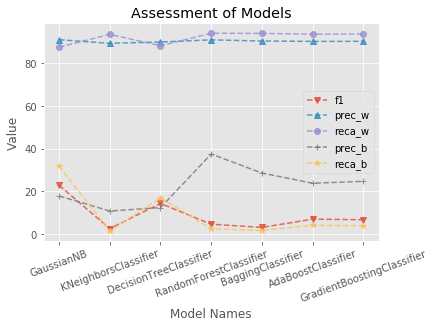

In [43]:
plt.style.use('ggplot')
xticks = np.arange(len(models.keys()))
plt.xticks(xticks, models.keys(), rotation=20)
markers = ['v', '^', 'o', '+', '*', 'D', 'p']

for ass_value, marker in zip(assess_dict.values(), markers):
    plt.plot(xticks, ass_value,
             linestyle='--', marker=marker, alpha=0.8)

plt.title('Assessment of Models')
plt.xlabel('Model Names')
plt.ylabel('Value')
plt.legend(assess_dict.keys())
plt.savefig('Assessment_of_Models.pdf')

In [44]:
for model_name, clf in models.items():
    pred_Y = clf.predict(pred_X)
    result = pred_head
    result['label'] = pred_Y

    student_ID = '1552667'
    prob_id = '2b'
    file_name = f'results/{student_ID}_{prob_id}_{model_name}.txt'
    with open(file_name, 'w') as f:
        for row in result.iterrows():
            row_series = row[1]
            if row_series.label == 1:
                ans = 'Yes'
            else:
                ans = 'No'
            f.write(f'{row_series.vipno},{row_series.pluno},{ans}\n')

# C-i

In [45]:
test_data_X = raw_data.query('20160301 <= sldatime < 20160601').copy() # Feature of test set: Mar. Apr. May.
test_data_Y = raw_data.query('20160601 <= sldatime < 20160701').copy() # Label of test set: June

pred_head, test_X, test_Y = construct_X_Y(3, ['vipno', 'pluno'], test_data_X, test_data_Y)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 413
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116      11     259        6
412  6227002180921663895      19     458        4
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 413
                   vipno prod_U_I_0
1            13325038116          8
412  6227002180921663895         15
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 413
                   vipno prod_U_B_0
1            13325038116          6
412  6227002180921663895          5
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 413
                   vipno prod_U_C_0
1            13325038116          7
412  6227002180921663895         14
Feature names are:  ['num_I_0', 'amt_I_0', 'days_I_0']
The DataFrame's row number is : 3295
         pluno num_I_0 amt_I_0 days_I_0
1     10000003       1       5        1
3294  40000700       1       1        1
Feature na

In [51]:
result_real = pred_head
result_real['label'] = test_Y['buy']
result_real = result_real.groupby('vipno').sum()
result_real.loc[result_real['label'] > 0, 'label'] = 1
print('Ground truth:')
print(result_real.label.value_counts())
print('-'*50 + '\n\n')

assess_dict = {
    'f1':[],
    'prec_w':[],
    'reca_w':[],
    'prec_b':[],
    'reca_b':[],
}

for model_name, clf in models.items():
    pred_Y = clf.predict(test_X)
    print(pred_Y)
    result_pred = pred_head
    result_pred['label'] = pred_Y
    result_pred = result_pred.groupby('vipno').sum()
    result_pred.loc[result_pred['label'] > 0, 'label'] = 1
    
    # count only the true label
    prec_b = precision_score(real_Y, pred_Y, average='binary') * 100
    reca_b = recall_score(real_Y, pred_Y, average='binary') * 100
    assess_dict['prec_b'].append(prec_b)
    assess_dict['reca_b'].append(reca_b)
    # count the weighted score
    prec_w = precision_score(real_Y, pred_Y, average='weighted') * 100
    reca_w = recall_score(real_Y, pred_Y, average='weighted') * 100
    assess_dict['prec_w'].append(prec_w)
    assess_dict['reca_w'].append(reca_w)
    # count the f1 score
    f1 = f1_score(real_Y, pred_Y) * 100
    assess_dict['f1'].append(f1)
    
    print(f'Model:{model_name} \n'
          f'f1_score = {"%.2f" % f1}%\n'
          f'precision_binary = {"%.2f" % prec_b}%, recall_binary = {"%.2f" % reca_b}%\n'
          f'precision_weighted = {"%.2f" % prec_w}%, recall_weighted = {"%.2f" % reca_w}%')
    print('-'*50)

Ground truth:
0    209
1    204
Name: label, dtype: int64
--------------------------------------------------


[0 0 0 ... 0 0 1]
Model:GaussianNB 
f1_score = 22.86%
precision_binary = 17.85%, recall_binary = 31.77%
precision_weighted = 91.10%, recall_weighted = 87.59%
--------------------------------------------------
[0 0 0 ... 0 0 0]
Model:KNeighborsClassifier 
f1_score = 2.52%
precision_binary = 10.77%, recall_binary = 1.43%
precision_weighted = 89.42%, recall_weighted = 93.61%
--------------------------------------------------
[0 0 0 ... 0 0 0]
Model:DecisionTreeClassifier 
f1_score = 14.30%
precision_binary = 12.39%, recall_binary = 16.90%
precision_weighted = 90.01%, recall_weighted = 88.27%
--------------------------------------------------
[0 0 0 ... 0 0 0]
Model:RandomForestClassifier 
f1_score = 4.59%
precision_binary = 37.50%, recall_binary = 2.44%
precision_weighted = 91.04%, recall_weighted = 94.12%
--------------------------------------------------
[0 0 0 ... 0 0 0]
Model

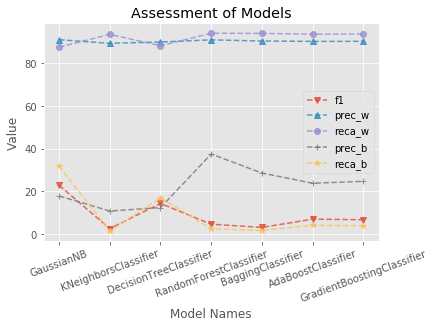

In [52]:
plt.style.use('ggplot')
xticks = np.arange(len(models.keys()))
plt.xticks(xticks, models.keys(), rotation=20)
markers = ['v', '^', 'o', '+', '*', 'D', 'p']

for ass_value, marker in zip(assess_dict.values(), markers):
    plt.plot(xticks, ass_value,
             linestyle='--', marker=marker, alpha=0.8)

plt.title('Assessment of Models')
plt.xlabel('Model Names')
plt.ylabel('Value')
plt.legend(assess_dict.keys())
plt.savefig('Assessment_of_Models_ci.pdf')

### Give the results of prediction.

In [54]:
pred_data_X = raw_data.query('20160501 <= sldatime < 20160801').copy() # Feature of predict set: May. June July
pred_head, pred_X = construct_X_Y(3, ['vipno', 'pluno'], pred_data_X)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 430
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116      17    1514        9
429  6227002180921663895      14     109        3
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 430
                   vipno prod_U_I_0
1            13325038116         13
429  6227002180921663895         12
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 430
                   vipno prod_U_B_0
1            13325038116          8
429  6227002180921663895          3
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 430
                   vipno prod_U_C_0
1            13325038116         11
429  6227002180921663895         11
Feature names are:  ['num_I_0', 'amt_I_0', 'days_I_0']
The DataFrame's row number is : 3302
         pluno num_I_0 amt_I_0 days_I_0
1     10000003       1       5        1
3301  40000700       1       1        1
Feature na

In [55]:
model_buy = {}
for model_name, clf in models.items():
    pred_Y = clf.predict(pred_X)
    result = pred_head
    result['label'] = pred_Y
    model_buy[model_name] = result.label
    student_ID = '1552667'
    prob_id = '2ci'
    file_name = f'results/{student_ID}_{prob_id}_{model_name}.txt'
    with open(file_name, 'w') as f:
        for vipno, group in result.groupby('vipno'):
            label = group.label.sum()
            if label > 0:
                ans = 'Yes'
            else:
                ans = 'False'
            f.write(f'{vipno},{ans}\n')

# C-ii
以用户购买商品品牌作为分类器（多）类别标签，构建用户交易特征与用户购买商品品牌（多）类别标签之间的机器学习模型，重复上述算法预测。

In [56]:
train_data_X = raw_data.query('20160201 <= sldatime < 20160501').copy() # Feature of train set: Feb. Mar. Apr.
train_data_Y = raw_data.query('20160501 <= sldatime < 20160601').copy() # Label of train set: May.
test_data_X = raw_data.query('20160301 <= sldatime < 20160601').copy() # Feature of test set: Mar. Apr. May.
test_data_Y = raw_data.query('20160601 <= sldatime < 20160701').copy() # Label of test set: June
pred_data_X = raw_data.query('20160501 <= sldatime < 20160801').copy() # Feature of predict set: May. June July

_, train_X, train_Y = construct_X_Y(3, ['vipno', 'bndno'], train_data_X, train_data_Y)
_, test_X, test_Y = construct_X_Y(3, ['vipno', 'bndno'], test_data_X, test_data_Y)
pred_head, pred_X = construct_X_Y(3, ['vipno', 'bndno'], pred_data_X)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 416
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116       5      55        3
415  6227002180921663895      21     476        5
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 416
                   vipno prod_U_I_0
1            13325038116          4
415  6227002180921663895         18
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 416
                   vipno prod_U_B_0
1            13325038116          3
415  6227002180921663895          7
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 416
                   vipno prod_U_C_0
1            13325038116          4
415  6227002180921663895         16
Feature names are:  ['num_B_0', 'amt_B_0', 'days_B_0']
The DataFrame's row number is : 681
     bndno num_B_0 amt_B_0 days_B_0
1    10003       1       5        1
680  34846       1       9        1
Feature names are:  ['p

The DataFrame's row number is : 318
                   vipno prod_U_I_1
1            13854627199          4
317  6227002180921663895         11
Feature names are:  ['prod_U_B_1']
The DataFrame's row number is : 318
                   vipno prod_U_B_1
1            13854627199          4
317  6227002180921663895          4
Feature names are:  ['prod_U_C_1']
The DataFrame's row number is : 318
                   vipno prod_U_C_1
1            13854627199          4
317  6227002180921663895         10
Feature names are:  ['num_B_1', 'amt_B_1', 'days_B_1']
The DataFrame's row number is : 408
     bndno num_B_1 amt_B_1 days_B_1
1    10007       8      43        8
407  34846       1       9        1
Feature names are:  ['prod_B_I_1']
The DataFrame's row number is : 408
     bndno prod_B_I_1
1    10007          5
407  34846          1
Feature names are:  ['prod_B_U_1']
The DataFrame's row number is : 408
     bndno prod_B_U_1
1    10007          8
407  34846          1
month: 4
Feature names ar

The DataFrame's row number is : 320
                   vipno prod_U_B_2
1            13325038116          4
319  6227002180921663895          2
Feature names are:  ['prod_U_C_2']
The DataFrame's row number is : 320
                   vipno prod_U_C_2
1            13325038116          6
319  6227002180921663895          6
Feature names are:  ['num_B_2', 'amt_B_2', 'days_B_2']
The DataFrame's row number is : 382
     bndno num_B_2 amt_B_2 days_B_2
1    10003       1       5        1
381  34856       2      19        1
Feature names are:  ['prod_B_I_2']
The DataFrame's row number is : 382
     bndno prod_B_I_2
1    10003          1
381  34856          1
Feature names are:  ['prod_B_U_2']
The DataFrame's row number is : 382
     bndno prod_B_U_2
1    10003          1
381  34856          1
month: 7
Feature names are:  ['num_U_3', 'amt_U_3', 'days_U_3']
The DataFrame's row number is : 315
                   vipno num_U_3 amt_U_3 days_U_3
1            13325038116       3    1137        2
314 

In [57]:
X1 = np.array(train_X)
Y1 = np.array(train_Y).reshape(len(train_Y))

assess_dict = {
    'f1':[],
    'prec_w':[],
    'reca_w':[],
    'prec_b':[],
    'reca_b':[],
}

print('Training dimension: ', X1.shape)
print('Testing demension', test_X.shape)

for model_name, clf in models.items():
    clf.fit(X1, Y1)
    pred_Y = clf.predict(test_X)
    real_Y = np.array(test_Y).reshape(len(test_Y))
    # count only the true label
    prec_b = precision_score(real_Y, pred_Y, average='binary') * 100
    reca_b = recall_score(real_Y, pred_Y, average='binary') * 100
    assess_dict['prec_b'].append(prec_b)
    assess_dict['reca_b'].append(reca_b)
    # count the weighted score
    prec_w = precision_score(real_Y, pred_Y, average='weighted') * 100
    reca_w = recall_score(real_Y, pred_Y, average='weighted') * 100
    assess_dict['prec_w'].append(prec_w)
    assess_dict['reca_w'].append(reca_w)
    # count the f1 score
    f1 = f1_score(real_Y, pred_Y) * 100
    assess_dict['f1'].append(f1)
    
    print(f'Model:{model_name} \n'
          f'f1_score = {"%.2f" % f1}%\n'
          f'precision_binary = {"%.2f" % prec_b}%, recall_binary = {"%.2f" % reca_b}%\n'
          f'precision_weighted = {"%.2f" % prec_w}%, recall_weighted = {"%.2f" % reca_w}%')
    print('-'*50)

Training dimension:  (4376, 44)
Testing demension (4133, 44)
Model:GaussianNB 
f1_score = 51.65%
precision_binary = 59.51%, recall_binary = 45.63%
precision_weighted = 86.90%, recall_weighted = 87.95%
--------------------------------------------------
Model:KNeighborsClassifier 
f1_score = 45.69%
precision_binary = 53.32%, recall_binary = 39.97%
precision_weighted = 85.28%, recall_weighted = 86.60%
--------------------------------------------------
Model:DecisionTreeClassifier 
f1_score = 37.47%
precision_binary = 34.75%, recall_binary = 40.65%
precision_weighted = 82.18%, recall_weighted = 80.86%
--------------------------------------------------
Model:RandomForestClassifier 
f1_score = 45.46%
precision_binary = 60.17%, recall_binary = 36.54%
precision_weighted = 85.97%, recall_weighted = 87.64%
--------------------------------------------------
Model:BaggingClassifier 
f1_score = 47.34%
precision_binary = 60.37%, recall_binary = 38.94%
precision_weighted = 86.27%, recall_weighted = 8

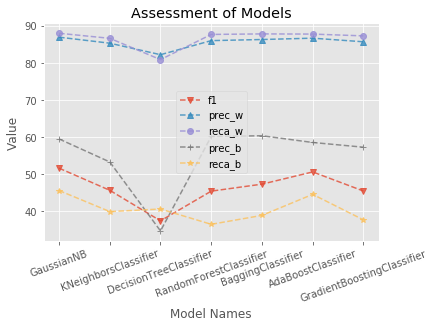

In [59]:
plt.style.use('ggplot')
xticks = np.arange(len(models.keys()))
plt.xticks(xticks, models.keys(), rotation=20)
markers = ['v', '^', 'o', '+', '*', 'D', 'p']

for ass_value, marker in zip(assess_dict.values(), markers):
    plt.plot(xticks, ass_value,
             linestyle='--', marker=marker, alpha=0.8)

plt.title('Assessment of Models')
plt.xlabel('Model Names')
plt.ylabel('Value')
plt.legend(assess_dict.keys())
plt.savefig('Assessment_of_Models_cii.pdf')

In [60]:
pred_data_X = raw_data.query('20160501 <= sldatime < 20160801').copy() # Feature of predict set: May. June July
pred_head, pred_X = construct_X_Y(3, ['vipno', 'bndno'], pred_data_X)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 430
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116      17    1514        9
429  6227002180921663895      14     109        3
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 430
                   vipno prod_U_I_0
1            13325038116         13
429  6227002180921663895         12
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 430
                   vipno prod_U_B_0
1            13325038116          8
429  6227002180921663895          3
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 430
                   vipno prod_U_C_0
1            13325038116         11
429  6227002180921663895         11
Feature names are:  ['num_B_0', 'amt_B_0', 'days_B_0']
The DataFrame's row number is : 634
     bndno num_B_0 amt_B_0 days_B_0
1    10003       3      20        3
633  34856       3      44        2
Feature names are:  ['p

In [61]:
for model_name, clf in models.items():
    pred_Y = clf.predict(pred_X)
    result = pred_head
    result['label'] = pred_Y

    student_ID = '1552667'
    prob_id = '2cii'
    file_name = f'results/{student_ID}_{prob_id}_{model_name}.txt'
    with open(file_name, 'w') as f:
        for row in result.iterrows():
            row_series = row[1]
            if row_series.label == 1:
                ans = 'Yes'
            else:
                ans = 'No'
            f.write(f'{row_series.vipno},{row_series.bndno},{ans}\n')

# C-iii

In [62]:
train_data_X = raw_data.query('20160201 <= sldatime < 20160501').copy() # Feature of train set: Feb. Mar. Apr.
train_data_Y = raw_data.query('20160501 <= sldatime < 20160601').copy() # Label of train set: May.
test_data_X = raw_data.query('20160301 <= sldatime < 20160601').copy() # Feature of test set: Mar. Apr. May.
test_data_Y = raw_data.query('20160601 <= sldatime < 20160701').copy() # Label of test set: June
pred_data_X = raw_data.query('20160501 <= sldatime < 20160801').copy() # Feature of predict set: May. June July

_, train_X, train_Y = construct_X_Y(3, ['vipno', 'dptno'], train_data_X, train_data_Y)
_, test_X, test_Y = construct_X_Y(3, ['vipno', 'dptno'], test_data_X, test_data_Y)
pred_head, pred_X = construct_X_Y(3, ['vipno', 'dptno'], pred_data_X)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 416
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116       5      55        3
415  6227002180921663895      21     476        5
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 416
                   vipno prod_U_I_0
1            13325038116          4
415  6227002180921663895         18
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 416
                   vipno prod_U_B_0
1            13325038116          3
415  6227002180921663895          7
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 416
                   vipno prod_U_C_0
1            13325038116          4
415  6227002180921663895         16
Feature names are:  ['num_C_0', 'amt_C_0', 'days_C_0']
The DataFrame's row number is : 812
     dptno num_C_0 amt_C_0 days_C_0
1    10001      13      90       12
811  40000      16    1973       15
Feature names are:  ['p

The DataFrame's row number is : 318
                   vipno prod_U_I_1
1            13854627199          4
317  6227002180921663895         11
Feature names are:  ['prod_U_B_1']
The DataFrame's row number is : 318
                   vipno prod_U_B_1
1            13854627199          4
317  6227002180921663895          4
Feature names are:  ['prod_U_C_1']
The DataFrame's row number is : 318
                   vipno prod_U_C_1
1            13854627199          4
317  6227002180921663895         10
Feature names are:  ['num_C_1', 'amt_C_1', 'days_C_1']
The DataFrame's row number is : 543
     dptno num_C_1 amt_C_1 days_C_1
1    10001       2       8        2
542  40000       7    1169        7
Feature names are:  ['prod_C_I_1']
The DataFrame's row number is : 543
     dptno prod_C_I_1
1    10001          2
542  40000          4
Feature names are:  ['prod_C_U_1']
The DataFrame's row number is : 543
     dptno prod_C_U_1
1    10001          2
542  40000          6
month: 4
Feature names ar

The DataFrame's row number is : 320
                   vipno prod_U_B_2
1            13325038116          4
319  6227002180921663895          2
Feature names are:  ['prod_U_C_2']
The DataFrame's row number is : 320
                   vipno prod_U_C_2
1            13325038116          6
319  6227002180921663895          6
Feature names are:  ['num_C_2', 'amt_C_2', 'days_C_2']
The DataFrame's row number is : 520
     dptno num_C_2 amt_C_2 days_C_2
1    10001       5      15        5
519  40000       3     413        3
Feature names are:  ['prod_C_I_2']
The DataFrame's row number is : 520
     dptno prod_C_I_2
1    10001          2
519  40000          3
Feature names are:  ['prod_C_U_2']
The DataFrame's row number is : 520
     dptno prod_C_U_2
1    10001          4
519  40000          3
month: 7
Feature names are:  ['num_U_3', 'amt_U_3', 'days_U_3']
The DataFrame's row number is : 315
                   vipno num_U_3 amt_U_3 days_U_3
1            13325038116       3    1137        2
314 

In [68]:
test_Y

,buy
0,0
1,0
2,0
3,1
4,0
5,0
6,0
7,0
8,0
9,1


In [69]:
assess_dict = {
    'f1':[],
    'prec_w':[],
    'reca_w':[],
    'prec_b':[],
    'reca_b':[],
}

X1 = np.array(train_X)
Y1 = np.array(train_Y).reshape(len(train_Y))

print('Training dimension: ', X1.shape)
print('Testing demension', test_X.shape)

for model_name, clf in models.items():
    clf.fit(X1, Y1)
    pred_Y = clf.predict(test_X)
    real_Y = np.array(test_Y).reshape(len(test_Y))
    
    # count only the true label
    prec_b = precision_score(real_Y, pred_Y, average='binary') * 100
    reca_b = recall_score(real_Y, pred_Y, average='binary') * 100
    assess_dict['prec_b'].append(prec_b)
    assess_dict['reca_b'].append(reca_b)
    # count the weighted score
    prec_w = precision_score(real_Y, pred_Y, average='weighted') * 100
    reca_w = recall_score(real_Y, pred_Y, average='weighted') * 100
    assess_dict['prec_w'].append(prec_w)
    assess_dict['reca_w'].append(reca_w)
    # count the f1 score
    f1 = f1_score(real_Y, pred_Y) * 100
    assess_dict['f1'].append(f1)
    
    print(f'Model:{model_name} \n'
          f'f1_score = {"%.2f" % f1}%\n'
          f'precision_binary = {"%.2f" % prec_b}%, recall_binary = {"%.2f" % reca_b}%\n'
          f'precision_weighted = {"%.2f" % prec_w}%, recall_weighted = {"%.2f" % reca_w}%')
    print('-'*50)

Training dimension:  (7246, 44)
Testing demension (6849, 44)
Model:GaussianNB 
f1_score = 31.05%
precision_binary = 23.48%, recall_binary = 45.84%
precision_weighted = 85.50%, recall_weighted = 78.54%
--------------------------------------------------
Model:KNeighborsClassifier 
f1_score = 10.48%
precision_binary = 24.74%, recall_binary = 6.65%
precision_weighted = 83.01%, recall_weighted = 88.03%
--------------------------------------------------
Model:DecisionTreeClassifier 
f1_score = 17.22%
precision_binary = 15.32%, recall_binary = 19.67%
precision_weighted = 82.31%, recall_weighted = 80.07%
--------------------------------------------------
Model:RandomForestClassifier 
f1_score = 9.47%
precision_binary = 38.24%, recall_binary = 5.40%
precision_weighted = 84.43%, recall_weighted = 89.11%
--------------------------------------------------
Model:BaggingClassifier 
f1_score = 10.53%
precision_binary = 33.83%, recall_binary = 6.23%
precision_weighted = 84.01%, recall_weighted = 88.83

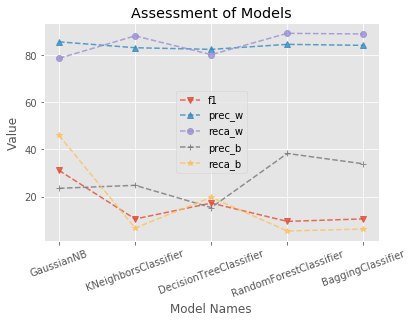

In [71]:
plt.style.use('ggplot')
xticks = np.arange(len(models.keys()))
plt.xticks(xticks, models.keys(), rotation=20)
markers = ['v', '^', 'o', '+', '*', 'D', 'p']

for ass_value, marker in zip(assess_dict.values(), markers):
    plt.plot(xticks, ass_value,
             linestyle='--', marker=marker, alpha=0.8)

plt.title('Assessment of Models')
plt.xlabel('Model Names')
plt.ylabel('Value')
plt.legend(assess_dict.keys())
plt.savefig('Assessment_of_Models_ciii.pdf')

In [65]:
pred_data_X = raw_data.query('20160501 <= sldatime < 20160801').copy() # Feature of predict set: May. June July
pred_head, pred_X = construct_X_Y(3, ['vipno', 'dptno'], pred_data_X)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 430
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116      17    1514        9
429  6227002180921663895      14     109        3
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 430
                   vipno prod_U_I_0
1            13325038116         13
429  6227002180921663895         12
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 430
                   vipno prod_U_B_0
1            13325038116          8
429  6227002180921663895          3
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 430
                   vipno prod_U_C_0
1            13325038116         11
429  6227002180921663895         11
Feature names are:  ['num_C_0', 'amt_C_0', 'days_C_0']
The DataFrame's row number is : 787
     dptno num_C_0 amt_C_0 days_C_0
1    10001      14      41       13
786  40000      15    2365       15
Feature names are:  ['p

In [72]:
for model_name, clf in models.items():
    pred_Y = clf.predict(pred_X)
    result = pred_head
    result['label'] = pred_Y

    student_ID = '1552667'
    prob_id = '2ciii'
    file_name = f'results/{student_ID}_{prob_id}_{model_name}.txt'
    with open(file_name, 'w') as f:
        for row in result.iterrows():
            row_series = row[1]
            if row_series.label == 1:
                ans = 'Yes'
            else:
                ans = 'No'
            f.write(f'{row_series.vipno},{row_series.dptno},{ans}\n')

# C-iv

In [80]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor

regression_models = {
    'BayesianRidge': BayesianRidge(),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'RandomForestRegressor': RandomForestRegressor(max_features=3, n_estimators=45),
    'BaggingRegressor': BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=0), random_state=0),
    'AdaBoostRegressor': AdaBoostRegressor(n_estimators=150, learning_rate=0.1),
    'GradientBoostingRegressor': GradientBoostingRegressor(max_depth=10, n_estimators=40),
}

In [75]:
def construct_amt_X_Y(k, PK, data_X, data_Y=None):
    # construct the features of the certain dataset by joining the feature table 
    X_base = unique_frame(data_X[PK], PK) # the base DataFrame only containing the PK
    data_generator = split_data_monthly(data_X)
    X = X_base
    for i in range(k+1):
        data = next(data_generator)
        for feature_PK in PK:
            feature_set = feature_dict[feature_PK]
            for func_tuple in feature_set.values():
                # extract the feature table from data_set
                feat = feature_func(data, func_tuple, i)
                X = pd.merge(X, feat, how='left', on=feature_PK)
    head_info = X[PK]
    X = X.drop(columns=PK).fillna(0)
    if data_Y is None:
        return head_info, X
    # construct the label for the certain data set
    Y = pd.DataFrame()
    df = data_X[['vipno', 'amt']].groupby('vipno').sum()
    Y['vipno'] = df.index
    Y['amt'] = np.array(df.amt)
    Y = Y.drop(columns=['vipno'])
    return head_info, X, Y

train_data_X = raw_data.query('20160201 <= sldatime < 20160501').copy() # Feature of train set: Feb. Mar. Apr.
train_data_Y = raw_data.query('20160501 <= sldatime < 20160601').copy() # Label of train set: May.
test_data_X = raw_data.query('20160301 <= sldatime < 20160601').copy() # Feature of test set: Mar. Apr. May.
test_data_Y = raw_data.query('20160601 <= sldatime < 20160701').copy() # Label of test set: June
pred_data_X = raw_data.query('20160501 <= sldatime < 20160801').copy() # Feature of predict set: May. June July

_, train_X, train_Y = construct_amt_X_Y(3, ['vipno'], train_data_X, train_data_Y)
_, test_X, test_Y = construct_amt_X_Y(3, ['vipno'], test_data_X, test_data_Y)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 416
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116       5      55        3
415  6227002180921663895      21     476        5
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 416
                   vipno prod_U_I_0
1            13325038116          4
415  6227002180921663895         18
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 416
                   vipno prod_U_B_0
1            13325038116          3
415  6227002180921663895          7
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 416
                   vipno prod_U_C_0
1            13325038116          4
415  6227002180921663895         16
2
4
month: 2
Feature names are:  ['num_U_1', 'amt_U_1', 'days_U_1']
The DataFrame's row number is : 318
                   vipno num_U_1 amt_U_1 days_U_1
1          1590120718170       2      11        1
317  6227002180921

In [81]:
X1 = np.array(train_X)
Y1 = np.array(train_Y).reshape(len(train_Y))
real_Y = np.array(test_Y).reshape(len(test_Y))

print('Training dimension: ', X1.shape)
print('Testing demension', test_X.shape)

error_dict = {}
for model_name, clf in regression_models.items():
    clf.fit(X1, Y1)
    pred_Y = clf.predict(test_X)
    # compute the distance
    diff = abs(pred_Y - real_Y)
    diff = np.sort(diff)
    down_samples = np.linspace(0, len(diff) - 1, 10, dtype=int)
    error = np.asarray(diff.take(down_samples))
    error_dict[model_name] = error
    print(f'Model:{model_name} \n', error)
    print('-'*50)

Training dimension:  (416, 24)
Testing demension (413, 24)
Model:BayesianRidge 
 [0.00416262 0.0590668  0.10708999 0.14750699 0.18972299 0.2336814
 0.28926741 0.34608192 0.41821074 0.61865834]
--------------------------------------------------
Model:KNeighborsRegressor 
 [4.40000e-02 1.46400e+00 3.14000e+00 4.90200e+00 6.31400e+00 8.95200e+00
 1.24060e+01 1.62300e+01 2.71200e+01 8.61752e+02]
--------------------------------------------------
Model:DecisionTreeRegressor 
 [0.0000e+00 2.6000e-01 6.3000e-01 1.0200e+00 1.5900e+00 2.2100e+00
 2.9000e+00 4.4200e+00 8.5300e+00 6.0218e+02]
--------------------------------------------------
Model:RandomForestRegressor 
 [1.15555556e-02 4.43444444e+00 9.13800000e+00 1.52851111e+01
 2.18524444e+01 3.12795556e+01 4.29040000e+01 5.70875556e+01
 8.95686667e+01 1.23084067e+03]
--------------------------------------------------
Model:BaggingRegressor 
 [0.00000e+00 2.09000e-01 4.79000e-01 7.86000e-01 1.04600e+00 1.41700e+00
 1.87200e+00 2.73100e+00 4.

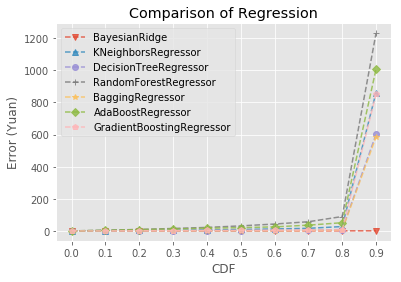

In [83]:
plt.style.use('ggplot')
#model_error['Gradient-Boosting'] = np.zeros(10)
markers = ['v', '^', 'o', '+', '*', 'D', 'p']

xticks = np.arange(0, 1, 1 / 10)
plt.xticks(xticks)
for clf_name, marker in zip(error_dict.keys(), markers):
    plt.plot(xticks, error_dict[clf_name],
             linestyle='--', marker=marker, alpha=0.8)
    
plt.title('Comparison of Regression')
plt.xlabel('CDF')
plt.ylabel('Error (Yuan)')
plt.legend(regression_models.keys())
plt.savefig('regression_comparison.pdf')

### Give the results of prediction.

In [78]:
pred_head, pred_X = construct_amt_X_Y(3, ['vipno'], pred_data_X)

Feature names are:  ['num_U_0', 'amt_U_0', 'days_U_0']
The DataFrame's row number is : 430
                   vipno num_U_0 amt_U_0 days_U_0
1            13325038116      17    1514        9
429  6227002180921663895      14     109        3
Feature names are:  ['prod_U_I_0']
The DataFrame's row number is : 430
                   vipno prod_U_I_0
1            13325038116         13
429  6227002180921663895         12
Feature names are:  ['prod_U_B_0']
The DataFrame's row number is : 430
                   vipno prod_U_B_0
1            13325038116          8
429  6227002180921663895          3
Feature names are:  ['prod_U_C_0']
The DataFrame's row number is : 430
                   vipno prod_U_C_0
1            13325038116         11
429  6227002180921663895         11
5
7
month: 5
Feature names are:  ['num_U_1', 'amt_U_1', 'days_U_1']
The DataFrame's row number is : 325
                   vipno num_U_1 amt_U_1 days_U_1
1            13325038116       6     204        3
324  6227002180921

In [84]:
new_model_buy = {}
for k1, k2 in zip(model_buy.keys(), regression_models.keys()):
    new_model_buy[k2] = model_buy[k1]
    
for model_name, clf in regression_models.items():
    pred_Y = clf.predict(pred_X)
    result = pred_head
    result['label'] = pred_Y
    result['buy'] = new_model_buy[model_name]
    student_ID = '1552667'
    prob_id = '2civ'
    file_name = f'results/{student_ID}_{prob_id}_{model_name}.txt'
    with open(file_name, 'w') as f:
        for row in result.iterrows():
            row_series = row[1]
            if row_series.buy == 1:
                f.write(f'{row_series.vipno},{row_series.label}\n')
            else:
                f.write(f'{row_series.vipno},0\n')